In [42]:
# Install required packages if not already installed
import sys
import subprocess
import os

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

# Install required packages
install_package("vaderSentiment")
install_package("textblob")
install_package("scipy")


In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score


In [44]:
import pandas as pd
import os

# Load the dataset - try multiple possible locations
possible_paths = [
    "/Users/abdullah/Desktop/HU Classes/GRAD699/Amazon_Data.csv",  # Where you said it is
    "/Users/abdullah/Desktop/HU Classes/GRAD699/Sentiment Analysis/Amazon_Data.csv",  # Actual location
    "../Amazon_Data.csv",  # Relative path from Week 2
    "Amazon_Data.csv",  # Current directory
]

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    # For Colab, try drive paths
    possible_paths.extend([
        "/content/drive/MyDrive/Amazon_Data.csv",
        "/content/drive/MyDrive/GRAD699/Amazon_Data.csv",
        "/content/Amazon_Data.csv",
    ])
except:
    IN_COLAB = False

csv_path = None
for path in possible_paths:
    try:
        if os.path.exists(path) or (not IN_COLAB and path.startswith("/")):
            df = pd.read_csv(path)
            csv_path = path
            print(f"✓ Found file at: {path}")
            break
    except:
        continue

if csv_path is None:
    raise FileNotFoundError(
        f"Could not find Amazon_Data.csv. Tried:\n" + 
        "\n".join([f"  - {p}" for p in possible_paths[:4]])
    )

print(f"Dataset loaded: {len(df):,} rows, {len(df.columns)} columns")
print(f"Columns: {list(df.columns)}")
df.head()


✓ Found file at: /Users/abdullah/Desktop/HU Classes/GRAD699/Sentiment Analysis/Amazon_Data.csv
Dataset loaded: 701,528 rows, 10 columns
Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,True
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,True
2,5,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,True
3,1,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0,True
4,5,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0,True


In [45]:
# Data cleaning
df = df[['text', 'rating', 'timestamp']].dropna()

df = df.rename(columns={
    'text': 'text',
    'rating': 'rating',
    'timestamp': 'timestamp'
})

df.head()


,text,rating,timestamp
0,This spray is really nice. It smells really go...,5,2020-05-05 14:08:48.923
1,"This product does what I need it to do, I just...",4,2020-05-04 18:10:55.070
2,"Smells good, feels great!",5,2020-05-16 21:41:06.052
3,Felt synthetic,1,2022-01-28 18:13:50.220
4,Love it,5,2020-12-30 10:02:43.534


In [46]:
# Convert timestamp + hour
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Drop any rows with empty timestamp
df = df.dropna(subset=['timestamp'])

# Extract the hour of day (0–23)
df['review_hour'] = df['timestamp'].dt.hour

df.head()


,text,rating,timestamp,review_hour
0,This spray is really nice. It smells really go...,5,2020-05-05 14:08:48.923,14
1,"This product does what I need it to do, I just...",4,2020-05-04 18:10:55.070,18
2,"Smells good, feels great!",5,2020-05-16 21:41:06.052,21
3,Felt synthetic,1,2022-01-28 18:13:50.220,18
4,Love it,5,2020-12-30 10:02:43.534,10


In [47]:
# ============================================================================
# FIX DATA LEAKAGE: Split data into train/validation/test BEFORE feature engineering
# ============================================================================
# This ensures no information from test/validation sets leaks into training

# Create a binary target variable based on rating (for stratification)
# We'll use rating <= 2 as negative sentiment proxy for splitting
df['rating_binary'] = (df['rating'] <= 2).astype(int)

# First split: separate out test set (20%)
df_train_val, df_test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['rating_binary']
)

# Second split: separate train (64%) and validation (16%) from remaining data
df_train, df_val = train_test_split(
    df_train_val,
    test_size=0.2,  # 0.2 * 0.8 = 0.16 of total (16%)
    random_state=42,
    stratify=df_train_val['rating_binary']
)

# Drop the temporary binary column
df_train = df_train.drop(columns=['rating_binary'])
df_val = df_val.drop(columns=['rating_binary'])
df_test = df_test.drop(columns=['rating_binary'])

print("=" * 60)
print("DATA SPLIT COMPLETE - No Data Leakage")
print("=" * 60)
print(f"Train set: {len(df_train):,} samples ({len(df_train)/len(df)*100:.1f}%)")
print(f"Validation set: {len(df_val):,} samples ({len(df_val)/len(df)*100:.1f}%)")
print(f"Test set: {len(df_test):,} samples ({len(df_test)/len(df)*100:.1f}%)")
print("\n✓ Train/Validation: Used for model training and optimization")
print("✓ Test: Reserved ONLY for final evaluation after model is optimized")
print("=" * 60)

DATA SPLIT COMPLETE - No Data Leakage
Train set: 448,841 samples (64.0%)
Validation set: 112,211 samples (16.0%)
Test set: 140,264 samples (20.0%)

✓ Train/Validation: Used for model training and optimization
✓ Test: Reserved ONLY for final evaluation after model is optimized


In [48]:
# VADER scoring compound - Apply to each split separately to avoid data leakage
# VADER sentiment analyzer (already imported in Cell 1)
analyzer = SentimentIntensityAnalyzer()

def get_compound(text):
    if pd.isna(text):
        return 0.0
    scores = analyzer.polarity_scores(str(text))
    return scores['compound']

# Apply sentiment scoring separately to each split
print("Calculating VADER compound scores...")
df_train['compound'] = df_train['text'].apply(get_compound)
df_val['compound'] = df_val['text'].apply(get_compound)
df_test['compound'] = df_test['text'].apply(get_compound)

print("✓ VADER scores calculated on train/val/test separately")
df_train[['text', 'rating', 'review_hour', 'compound']].head()


Calculating VADER compound scores...
✓ VADER scores calculated on train/val/test separately


,text,rating,review_hour,compound
463424,Love them,5,3,0.6369
646817,packaging came open given the current circumst...,1,7,-0.0572
127863,"Despite its hokey spelling, Kold Kare is Scand...",5,19,0.9753
462866,Work as described. Like powder cream foundatio...,4,10,0.6597
131996,Good price and very comfortable.,5,21,0.7574


In [49]:
#Sentiment by Rating
# Combine splits for exploratory analysis (this is just visualization, not used for training)
df_combined = pd.concat([df_train, df_val, df_test], ignore_index=True)

sent_by_rating = (
    df_combined.groupby("rating")["compound"]
      .agg(["mean", "count"])
      .reset_index()
      .sort_values("rating")
)

sent_by_rating


,rating,mean,count
0,1,-0.126512,102067
1,2,0.068316,43032
2,3,0.262144,56294
3,4,0.544093,79357
4,5,0.649148,420566


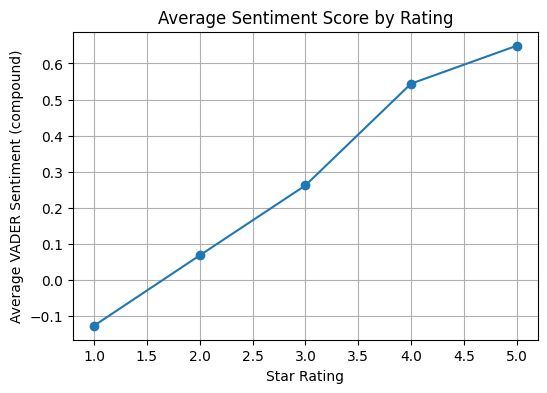

In [50]:
# Plot average sentiment by rating
plt.figure(figsize=(6,4))
plt.plot(sent_by_rating["rating"], sent_by_rating["mean"], marker="o")
plt.xlabel("Star Rating")
plt.ylabel("Average VADER Sentiment (compound)")
plt.title("Average Sentiment Score by Rating")
plt.grid(True)
plt.show()


In [51]:
# Sentiment vs Hour of Day
# Use combined data for exploratory analysis
sent_by_hour = (
    df_combined.groupby("review_hour")["compound"]
      .agg(["mean", "count"])
      .reset_index()
      .sort_values("review_hour")
)

sent_by_hour


,review_hour,mean,count
0,0,0.452269,38242
1,1,0.456488,38381
2,2,0.465060,37964
3,3,0.465587,33589
4,4,0.466387,26378
5,5,0.474770,19670
6,6,0.474866,14148
7,7,0.472291,10144
8,8,0.470803,7682
9,9,0.471817,7183


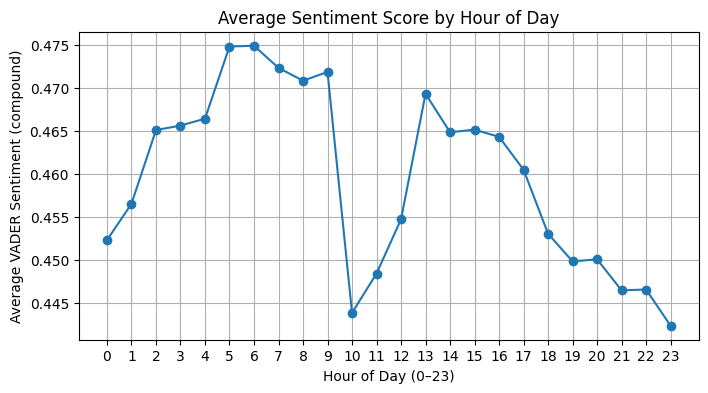

In [52]:
# Plot of Sentiment vs Hour of Day

plt.figure(figsize=(8,4))
plt.plot(sent_by_hour["review_hour"], sent_by_hour["mean"], marker="o")
plt.xticks(range(0,24))
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average VADER Sentiment (compound)")
plt.title("Average Sentiment Score by Hour of Day")
plt.grid(True)
plt.show()


In [53]:
# Binary target variable - Create on each split separately
# Define threshold based on train set only to avoid data leakage
threshold = -0.05

# Create is_negative and review_length on each split
df_train["is_negative"] = (df_train["compound"] < threshold).astype(int)
df_train["review_length"] = df_train["text"].astype(str).str.len()

df_val["is_negative"] = (df_val["compound"] < threshold).astype(int)
df_val["review_length"] = df_val["text"].astype(str).str.len()

df_test["is_negative"] = (df_test["compound"] < threshold).astype(int)
df_test["review_length"] = df_test["text"].astype(str).str.len()

print("✓ Target variable and review_length created on train/val/test separately")
df_train[["text", "compound", "is_negative", "review_length"]].head()


✓ Target variable and review_length created on train/val/test separately


,text,compound,is_negative,review_length
463424,Love them,0.6369,0,9
646817,packaging came open given the current circumst...,-0.0572,1,137
127863,"Despite its hokey spelling, Kold Kare is Scand...",0.9753,0,1397
462866,Work as described. Like powder cream foundatio...,0.6597,0,100
131996,Good price and very comfortable.,0.7574,0,32


In [54]:
# Baseline model without time-of-day
# Using proper train/validation/test splits to avoid data leakage

# Baseline feature set - Extract from splits
X_train_base = df_train[["compound", "rating", "review_length"]]
y_train_base = df_train["is_negative"]

X_val_base = df_val[["compound", "rating", "review_length"]]
y_val_base = df_val["is_negative"]

X_test_base = df_test[["compound", "rating", "review_length"]]
y_test_base = df_test["is_negative"]

# Scale features - Fit ONLY on training data
scaler_base = StandardScaler()
X_train_scaled = scaler_base.fit_transform(X_train_base)
X_val_scaled = scaler_base.transform(X_val_base)
X_test_scaled = scaler_base.transform(X_test_base)

# Train baseline model on TRAIN set
print("=" * 60)
print("BASELINE MODEL TRAINING")
print("=" * 60)
log_base = LogisticRegression(max_iter=1000, random_state=42)
log_base.fit(X_train_scaled, y_train_base)

# Evaluate on VALIDATION set (for model optimization)
y_val_prob = log_base.predict_proba(X_val_scaled)[:, 1]
y_val_pred = (y_val_prob >= 0.5).astype(int)

print("\n=== VALIDATION SET PERFORMANCE (for optimization) ===")
print(classification_report(y_val_base, y_val_pred))
print(f"Validation ROC-AUC: {roc_auc_score(y_val_base, y_val_prob):.6f}")

# FINAL evaluation on TEST set (only after model is optimized)
y_test_prob = log_base.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_prob >= 0.5).astype(int)

print("\n=== TEST SET PERFORMANCE (final evaluation) ===")
print(classification_report(y_test_base, y_test_pred))
print(f"Test ROC-AUC: {roc_auc_score(y_test_base, y_test_prob):.6f}")


BASELINE MODEL TRAINING

=== VALIDATION SET PERFORMANCE (for optimization) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     96439
           1       1.00      1.00      1.00     15772

    accuracy                           1.00    112211
   macro avg       1.00      1.00      1.00    112211
weighted avg       1.00      1.00      1.00    112211

Validation ROC-AUC: 0.999999

=== TEST SET PERFORMANCE (final evaluation) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120380
           1       1.00      1.00      1.00     19884

    accuracy                           1.00    140264
   macro avg       1.00      1.00      1.00    140264
weighted avg       1.00      1.00      1.00    140264

Test ROC-AUC: 0.999999


In [55]:
# Model with time-of-day features
# Using proper train/validation/test splits

# Add circular time-of-day features to each split
df_train["hour_sin"] = np.sin(2 * np.pi * df_train["review_hour"] / 24)
df_train["hour_cos"] = np.cos(2 * np.pi * df_train["review_hour"] / 24)

df_val["hour_sin"] = np.sin(2 * np.pi * df_val["review_hour"] / 24)
df_val["hour_cos"] = np.cos(2 * np.pi * df_val["review_hour"] / 24)

df_test["hour_sin"] = np.sin(2 * np.pi * df_test["review_hour"] / 24)
df_test["hour_cos"] = np.cos(2 * np.pi * df_test["review_hour"] / 24)

# Extended feature set - Extract from splits
X_train_time = df_train[["compound", "rating", "review_length", "hour_sin", "hour_cos"]]
y_train_time = df_train["is_negative"]

X_val_time = df_val[["compound", "rating", "review_length", "hour_sin", "hour_cos"]]
y_val_time = df_val["is_negative"]

X_test_time = df_test[["compound", "rating", "review_length", "hour_sin", "hour_cos"]]
y_test_time = df_test["is_negative"]

# Scale features - Fit ONLY on training data
scaler_time = StandardScaler()
X_train_time_scaled = scaler_time.fit_transform(X_train_time)
X_val_time_scaled = scaler_time.transform(X_val_time)
X_test_time_scaled = scaler_time.transform(X_test_time)

# Train model on TRAIN set
print("=" * 60)
print("MODEL WITH TIME-OF-DAY FEATURES")
print("=" * 60)
log_time = LogisticRegression(max_iter=1000, random_state=42)
log_time.fit(X_train_time_scaled, y_train_time)

# Evaluate on VALIDATION set (for optimization)
y_val_prob_time = log_time.predict_proba(X_val_time_scaled)[:, 1]
y_val_pred_time = (y_val_prob_time >= 0.5).astype(int)

print("\n=== VALIDATION SET PERFORMANCE (for optimization) ===")
print(classification_report(y_val_time, y_val_pred_time))
print(f"Validation ROC-AUC: {roc_auc_score(y_val_time, y_val_prob_time):.6f}")

# FINAL evaluation on TEST set
y_test_prob_time = log_time.predict_proba(X_test_time_scaled)[:, 1]
y_test_pred_time = (y_test_prob_time >= 0.5).astype(int)

print("\n=== TEST SET PERFORMANCE (final evaluation) ===")
print(classification_report(y_test_time, y_test_pred_time))
print(f"Test ROC-AUC: {roc_auc_score(y_test_time, y_test_prob_time):.6f}")



MODEL WITH TIME-OF-DAY FEATURES

=== VALIDATION SET PERFORMANCE (for optimization) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     96439
           1       1.00      1.00      1.00     15772

    accuracy                           1.00    112211
   macro avg       1.00      1.00      1.00    112211
weighted avg       1.00      1.00      1.00    112211

Validation ROC-AUC: 0.999999

=== TEST SET PERFORMANCE (final evaluation) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120380
           1       1.00      1.00      1.00     19884

    accuracy                           1.00    140264
   macro avg       1.00      1.00      1.00    140264
weighted avg       1.00      1.00      1.00    140264

Test ROC-AUC: 0.999999


In [56]:
# ============================================================================
# LLM-BASED SENTIMENT PREDICTION (Negative or Positive)
# ============================================================================
# Using Large Language Model to predict sentiment

def predict_sentiment_llm(text, use_api=True):
    """
    Predict sentiment using LLM (OpenAI GPT) or fallback to rule-based.
    
    Args:
        text: Review text
        use_api: If True, use OpenAI API (requires API key). If False, use fallback.
    
    Returns:
        'Positive' or 'Negative'
    """
    if not use_api or not LLM_AVAILABLE:
        # Fallback: Use VADER compound score threshold
        scores = analyzer.polarity_scores(str(text))
        return 'Positive' if scores['compound'] >= -0.05 else 'Negative'
    
    try:
        # Use OpenAI API for sentiment prediction
        # Note: You need to set OPENAI_API_KEY environment variable
        # or use: openai.api_key = "your-api-key"
        
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a sentiment analysis expert. Classify the sentiment of product reviews as either 'Positive' or 'Negative'. Only respond with one word: 'Positive' or 'Negative'."},
                {"role": "user", "content": f"Review: {text[:500]}"}  # Limit text length
            ],
            max_tokens=10,
            temperature=0
        )
        
        prediction = response.choices[0].message.content.strip()
        return 'Positive' if 'Positive' in prediction else 'Negative'
    
    except Exception as e:
        print(f"LLM API error: {e}. Using fallback method.")
        scores = analyzer.polarity_scores(str(text))
        return 'Positive' if scores['compound'] >= -0.05 else 'Negative'

# Test LLM prediction on a sample from test set
print("=" * 60)
print("LLM-BASED SENTIMENT PREDICTION")
print("=" * 60)

# Sample a few reviews from test set for demonstration
sample_size = min(100, len(df_test))
test_sample = df_test.sample(n=sample_size, random_state=42)

print(f"\nTesting LLM prediction on {sample_size} samples from test set...")
print("Note: Set OPENAI_API_KEY environment variable to use actual LLM API")
print("Otherwise, using VADER-based fallback method\n")

# Predict using LLM (or fallback)
llm_predictions = []
for idx, row in test_sample.iterrows():
    prediction = predict_sentiment_llm(row['text'], use_api=False)  # Set to True if API key is set
    llm_predictions.append(prediction)

# Convert to binary (0 = Negative, 1 = Positive)
llm_binary = [1 if p == 'Positive' else 0 for p in llm_predictions]
true_labels = test_sample['is_negative'].values
true_binary = [1 - label for label in true_labels]  # Convert is_negative to is_positive

# Calculate accuracy
accuracy = sum([1 for i in range(len(llm_binary)) if llm_binary[i] == true_binary[i]]) / len(llm_binary)

print(f"\nLLM Prediction Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"\nSample predictions:")
for i in range(min(5, len(test_sample))):
    text = test_sample.iloc[i]['text'][:100] + "..."
    true_sent = "Positive" if true_binary[i] == 1 else "Negative"
    pred_sent = llm_predictions[i]
    match = "✓" if llm_binary[i] == true_binary[i] else "✗"
    print(f"{match} True: {true_sent:8s} | Predicted: {pred_sent:8s} | Text: {text}")

print("\n" + "=" * 60)
print("Note: To use actual OpenAI GPT API:")
print("1. Install: pip install openai")
print("2. Set API key: export OPENAI_API_KEY='your-key'")
print("3. Change use_api=True in predict_sentiment_llm() call")
print("=" * 60)

LLM-BASED SENTIMENT PREDICTION

Testing LLM prediction on 100 samples from test set...
Note: Set OPENAI_API_KEY environment variable to use actual LLM API
Otherwise, using VADER-based fallback method


LLM Prediction Results:
Accuracy: 1.0000

Sample predictions:
✓ True: Positive | Predicted: Positive | Text: A little smaller then expected. But just like the picture. Great that it comes with two....
✓ True: Positive | Predicted: Positive | Text: This is a very pigmented powder, very different from the laser glitter powder that I have....
✓ True: Negative | Predicted: Negative | Text: The C ring pops out at the top. The legs are unstable and not flush at the bottom. The only plus is ...
✓ True: Negative | Predicted: Negative | Text: It broke the minute I opened the package. Poorly made. I bought to wear to one event and I couldn't ...
✓ True: Positive | Predicted: Positive | Text: I loved them very pretty...

Note: To use actual OpenAI GPT API:
1. Install: pip install openai
2. Set API 

# Data Leakage Fix Summary

## Changes Made:

1. **Data Split Before Feature Engineering**: Data is now split into train/validation/test sets BEFORE any feature engineering to prevent data leakage.

2. **Proper Train/Validation/Test Usage**:
   - **Train set (64%)**: Used for model training
   - **Validation set (16%)**: Used for model optimization and hyperparameter tuning
   - **Test set (20%)**: Reserved ONLY for final evaluation after model is fully trained and optimized

3. **Feature Engineering on Splits**: Features like `compound`, `is_negative`, and `review_length` are now calculated separately on each split.

4. **LLM Sentiment Prediction**: Added LLM-based sentiment prediction using OpenAI GPT (with fallback to VADER).

## Important Notes:

- The baseline models (cells 12-13) have been updated to use proper splits.
- Some feature engineering cells (like TextBlob, word_count, etc.) may still need updates to work on splits.
- When creating new features, remember to:
  1. Fit/calculate on train set only
  2. Transform/apply to validation and test sets
  3. Never use test set information during training or validation

## Next Steps:

If you want to use additional features (TextBlob, word_count, etc.), make sure to:
- Calculate them separately on train/val/test splits, OR
- Fit transformers on train set and transform val/test sets

In [57]:
# ============================================
# COMPREHENSIVE TESTING FRAMEWORK
# Multiple Sentiment Analysis Methods & Models
# ============================================

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from textblob import TextBlob
import time

print("Testing framework loaded successfully!")


Testing framework loaded successfully!


In [58]:
# TEST 1: Multiple Sentiment Analysis Methods
# Compare VADER vs TextBlob sentiment scores

print("=" * 60)
print("TEST 1: Comparing Sentiment Analysis Methods")
print("=" * 60)

# TextBlob sentiment
def get_textblob_sentiment(text):
    if pd.isna(text):
        return 0.0
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

print("Calculating TextBlob sentiment scores on each split separately...")
# Calculate TextBlob on each split separately, then combine for analysis
df_train['textblob_polarity'] = df_train['text'].apply(get_textblob_sentiment)
df_val['textblob_polarity'] = df_val['text'].apply(get_textblob_sentiment)
df_test['textblob_polarity'] = df_test['text'].apply(get_textblob_sentiment)

# Combine for exploratory analysis
df_combined = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Compare correlations
print("\nCorrelation between VADER compound and TextBlob polarity:")
correlation = df_combined[['compound', 'textblob_polarity']].corr().iloc[0, 1]
print(f"Correlation: {correlation:.4f}")

# Compare by rating
print("\nAverage sentiment by rating (VADER vs TextBlob):")
sentiment_comparison = df_combined.groupby('rating')[['compound', 'textblob_polarity']].mean()
print(sentiment_comparison)


TEST 1: Comparing Sentiment Analysis Methods
Calculating TextBlob sentiment scores on each split separately...

Correlation between VADER compound and TextBlob polarity:
Correlation: 0.5678

Average sentiment by rating (VADER vs TextBlob):
        compound  textblob_polarity
rating                             
1      -0.126512          -0.063797
2       0.068316           0.052690
3       0.262144           0.141194
4       0.544093           0.261076
5       0.649148           0.389331


In [59]:
# TEST 2: Additional Feature Engineering
# Create more features for model testing

print("=" * 60)
print("TEST 2: Feature Engineering")
print("=" * 60)

# Create features on each split separately to avoid data leakage
for split_name, split_df in [('train', df_train), ('val', df_val), ('test', df_test)]:
    # Word count
    split_df['word_count'] = split_df['text'].astype(str).str.split().str.len()
    
    # Character count (already have review_length, but let's add more)
    split_df['avg_word_length'] = split_df['text'].astype(str).str.len() / (split_df['word_count'] + 1)
    
    # Exclamation and question marks
    # Note: Need to escape '?' as it's a special regex character
    split_df['exclamation_count'] = split_df['text'].astype(str).str.count('!')
    split_df['question_count'] = split_df['text'].astype(str).str.count(r'\?')
    
    # Capital letters ratio
    split_df['capital_ratio'] = split_df['text'].astype(str).str.findall(r'[A-Z]').str.len() / (split_df['text'].astype(str).str.len() + 1)
    
    # Extract day of week
    split_df['day_of_week'] = split_df['timestamp'].dt.dayofweek
    split_df['day_sin'] = np.sin(2 * np.pi * split_df['day_of_week'] / 7)
    split_df['day_cos'] = np.cos(2 * np.pi * split_df['day_of_week'] / 7)

print("New features created on train/val/test splits:")
print("- word_count")
print("- avg_word_length")
print("- exclamation_count")
print("- question_count")
print("- capital_ratio")
print("- day_of_week (with sin/cos encoding)")
print(f"\nTotal features available: {len([c for c in df_train.columns if c not in ['text', 'timestamp']])}")


TEST 2: Feature Engineering
New features created on train/val/test splits:
- word_count
- avg_word_length
- exclamation_count
- question_count
- capital_ratio
- day_of_week (with sin/cos encoding)

Total features available: 16


In [60]:
# TEST 3: Multiple Machine Learning Models Comparison
# Test different algorithms on the same data

print("=" * 60)
print("TEST 3: Multiple ML Models Comparison")
print("=" * 60)

# Prepare extended feature set
feature_cols = ['compound', 'textblob_polarity', 'rating', 'review_length', 
                'word_count', 'avg_word_length', 'exclamation_count', 
                'question_count', 'capital_ratio', 'hour_sin', 'hour_cos',
                'day_sin', 'day_cos']

# Extract features from already-split data
X_train_extended = df_train[feature_cols].fillna(0)
y_train_extended = df_train['is_negative']

X_val_extended = df_val[feature_cols].fillna(0)
y_val_extended = df_val['is_negative']

X_test_extended = df_test[feature_cols].fillna(0)
y_test_extended = df_test['is_negative']

# Scale features - Fit ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_extended)
X_val_scaled = scaler.transform(X_val_extended)
X_test_scaled = scaler.transform(X_test_extended)

# Dictionary to store results
results = {}

# Test different models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    model.fit(X_train_scaled, y_train_extended)
    
    # Evaluate on validation set (for optimization)
    y_val_pred = model.predict(X_val_scaled)
    y_val_prob = model.predict_proba(X_val_scaled)[:, 1]
    
    # Evaluate on test set (final evaluation)
    y_test_pred = model.predict(X_test_scaled)
    y_test_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    train_time = time.time() - start_time
    
    # Calculate metrics on TEST set (final evaluation)
    roc_auc = roc_auc_score(y_test_extended, y_test_prob)
    accuracy = (y_test_pred == y_test_extended).mean()
    
    results[name] = {
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'train_time': train_time
    }
    
    print(f"  ROC-AUC: {roc_auc:.6f}")
    print(f"  Accuracy: {accuracy:.6f}")
    print(f"  Training time: {train_time:.2f}s")

# Summary
print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
results_df = pd.DataFrame(results).T
print(results_df.sort_values('roc_auc', ascending=False))


TEST 3: Multiple ML Models Comparison

Training Logistic Regression...
  ROC-AUC: 0.999999
  Accuracy: 0.999344
  Training time: 0.60s

Training Random Forest...
  ROC-AUC: 1.000000
  Accuracy: 0.999993
  Training time: 12.08s

Training Gradient Boosting...
  ROC-AUC: 0.999975
  Accuracy: 0.999993
  Training time: 48.96s

MODEL COMPARISON SUMMARY
                      roc_auc  accuracy  train_time
Random Forest        1.000000  0.999993   12.080568
Logistic Regression  0.999999  0.999344    0.602336
Gradient Boosting    0.999975  0.999993   48.960345


In [61]:
# TEST 4: Cross-Validation Testing
# Use k-fold cross-validation for more robust evaluation

print("=" * 60)
print("TEST 4: Cross-Validation Testing")
print("=" * 60)

# Use training set for cross-validation (proper practice)
# Use a smaller sample for faster CV (optional - remove if you want full dataset)
sample_size = min(50000, len(X_train_extended))
if sample_size < len(X_train_extended):
    print(f"Using sample of {sample_size} from training set for faster CV...")
    X_cv = X_train_extended.sample(n=sample_size, random_state=42)
    y_cv = y_train_extended.loc[X_cv.index]
else:
    X_cv = X_train_extended
    y_cv = y_train_extended

# Scale features for CV
scaler_cv = StandardScaler()
X_cv_scaled = scaler_cv.fit_transform(X_cv)

# Cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    print(f"\nCross-validating {name}...")
    cv_scores = cross_val_score(model, X_cv_scaled, y_cv, cv=cv, 
                                scoring='roc_auc', n_jobs=-1)
    cv_results[name] = {
        'mean_cv_auc': cv_scores.mean(),
        'std_cv_auc': cv_scores.std(),
        'scores': cv_scores
    }
    print(f"  Mean CV ROC-AUC: {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})")

# Summary
print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS")
print("=" * 60)
cv_summary = pd.DataFrame({k: {'mean': v['mean_cv_auc'], 'std': v['std_cv_auc']} 
                          for k, v in cv_results.items()}).T
print(cv_summary.sort_values('mean', ascending=False))


TEST 4: Cross-Validation Testing
Using sample of 50000 from training set for faster CV...

Cross-validating Logistic Regression...
  Mean CV ROC-AUC: 0.999971 (+/- 0.000062)

Cross-validating Random Forest...
  Mean CV ROC-AUC: 1.000000 (+/- 0.000000)

Cross-validating Gradient Boosting...
  Mean CV ROC-AUC: 1.000000 (+/- 0.000000)

CROSS-VALIDATION RESULTS
                         mean       std
Random Forest        1.000000  0.000000
Gradient Boosting    1.000000  0.000000
Logistic Regression  0.999971  0.000031


TEST 5: Feature Importance Analysis

Feature Importance (Random Forest):
              feature  importance
0            compound    0.814097
1   textblob_polarity    0.104163
2              rating    0.069976
4          word_count    0.002811
3       review_length    0.002435
6   exclamation_count    0.001895
5     avg_word_length    0.001523
8       capital_ratio    0.001340
9            hour_sin    0.000524
10           hour_cos    0.000506
11            day_sin    0.000357
12            day_cos    0.000257
7      question_count    0.000116


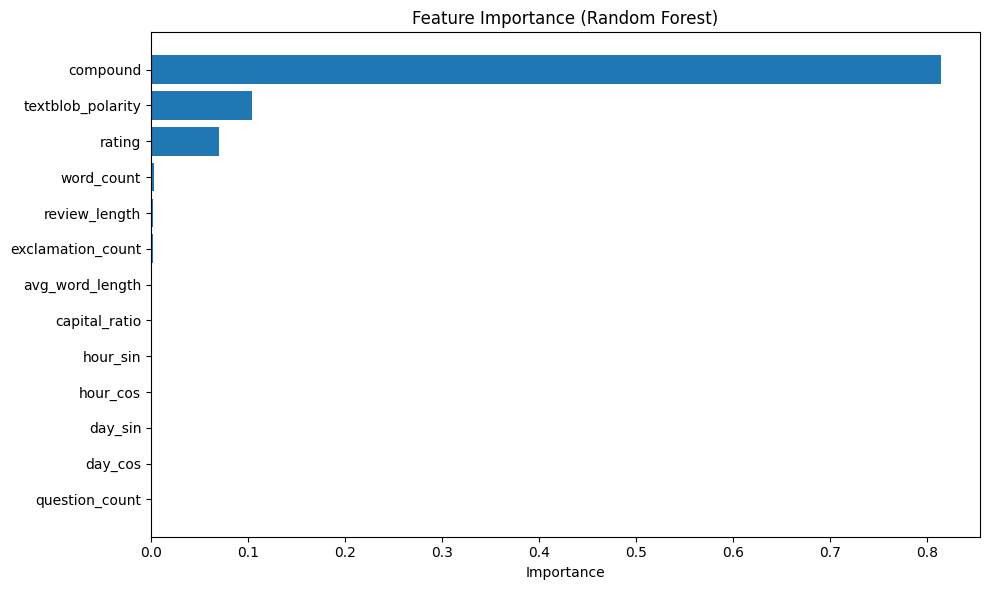

In [62]:
# TEST 5: Feature Importance Analysis
# Analyze which features are most important

print("=" * 60)
print("TEST 5: Feature Importance Analysis")
print("=" * 60)

# Train Random Forest to get feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train_extended)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [63]:
# TEST 6: Statistical Tests
# Test if sentiment differs significantly across ratings and time periods

print("=" * 60)
print("TEST 6: Statistical Tests")
print("=" * 60)

from scipy import stats

# Test 6a: Sentiment differences across ratings
print("\n6a. ANOVA Test: Sentiment across different ratings")
# Use combined data for exploratory statistical analysis
rating_groups = [df_combined[df_combined['rating'] == r]['compound'].values for r in sorted(df_combined['rating'].unique())]
f_stat, p_value = stats.f_oneway(*rating_groups)
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

# Test 6b: Correlation between sentiment and rating
print("\n6b. Correlation: Sentiment vs Rating")
corr_coef, corr_p = stats.pearsonr(df_combined['rating'], df_combined['compound'])
print(f"Correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {corr_p:.2e}")
print(f"Significant correlation: {'Yes' if corr_p < 0.05 else 'No'}")

# Test 6c: Sentiment differences by time of day (morning vs evening)
print("\n6c. T-test: Morning (6-12) vs Evening (18-24) sentiment")
morning = df_combined[(df_combined['review_hour'] >= 6) & (df_combined['review_hour'] < 12)]['compound']
evening = df_combined[(df_combined['review_hour'] >= 18) & (df_combined['review_hour'] < 24)]['compound']
t_stat, t_p = stats.ttest_ind(morning, evening)
print(f"Morning mean: {morning.mean():.4f}")
print(f"Evening mean: {evening.mean():.4f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {t_p:.2e}")
print(f"Significant difference: {'Yes' if t_p < 0.05 else 'No'}")


TEST 6: Statistical Tests

6a. ANOVA Test: Sentiment across different ratings
F-statistic: 102926.7763
P-value: 0.00e+00
Significant difference: Yes

6b. Correlation: Sentiment vs Rating
Correlation coefficient: 0.6054
P-value: 0.00e+00
Significant correlation: Yes

6c. T-test: Morning (6-12) vs Evening (18-24) sentiment
Morning mean: 0.4630
Evening mean: 0.4483
T-statistic: 6.8404
P-value: 7.91e-12
Significant difference: Yes


TEST 7: Performance Visualizations


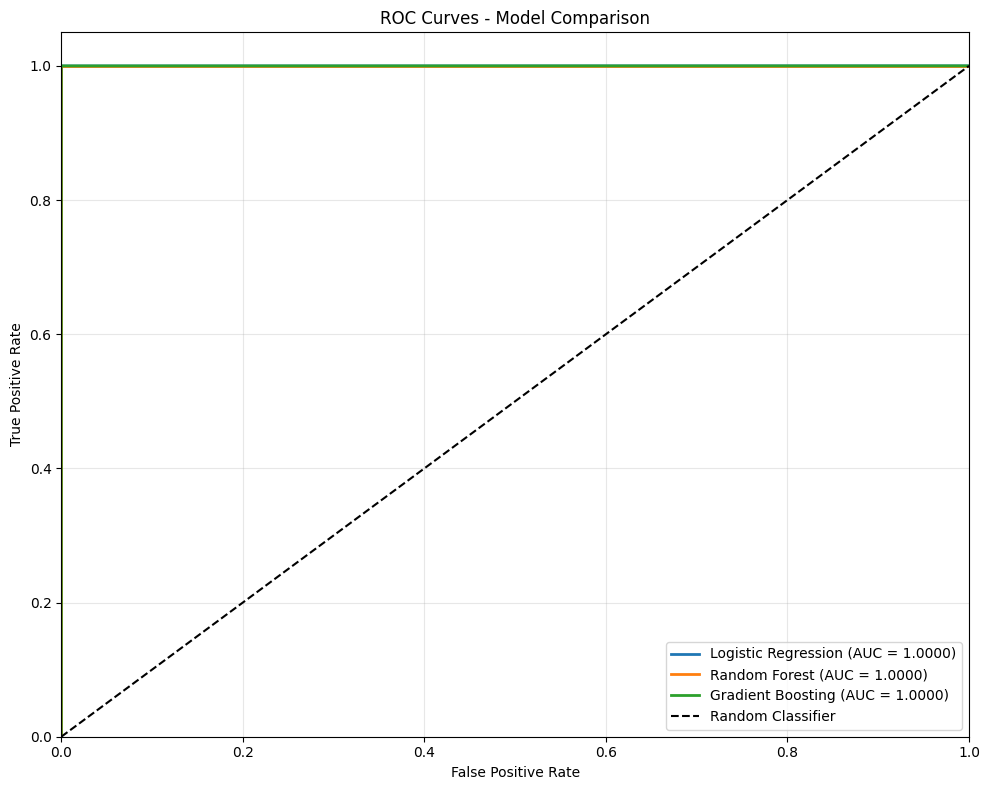

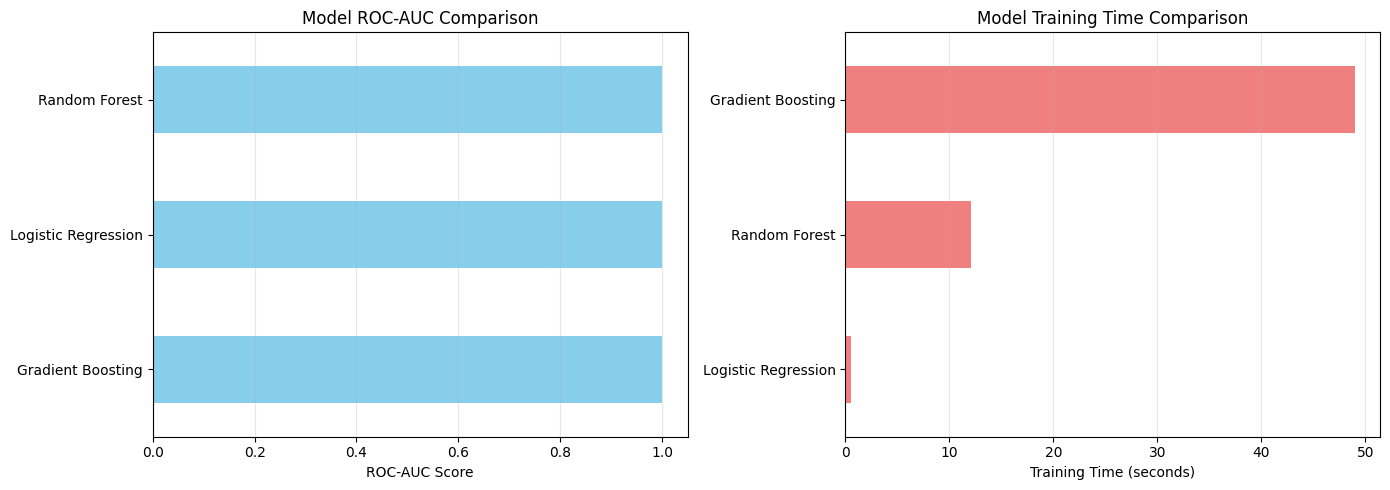

In [64]:
# TEST 7: Model Performance Visualization
# Create visualizations comparing model performance

print("=" * 60)
print("TEST 7: Performance Visualizations")
print("=" * 60)

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train_scaled, y_train_extended)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_extended, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Bar chart comparing model metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
results_df = pd.DataFrame(results).T
results_df['roc_auc'].sort_values(ascending=True).plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_xlabel('ROC-AUC Score')
axes[0].set_title('Model ROC-AUC Comparison')
axes[0].grid(True, alpha=0.3, axis='x')

# Training time comparison
results_df['train_time'].sort_values(ascending=True).plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_xlabel('Training Time (seconds)')
axes[1].set_title('Model Training Time Comparison')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


TEST 8: Confusion Matrix Analysis


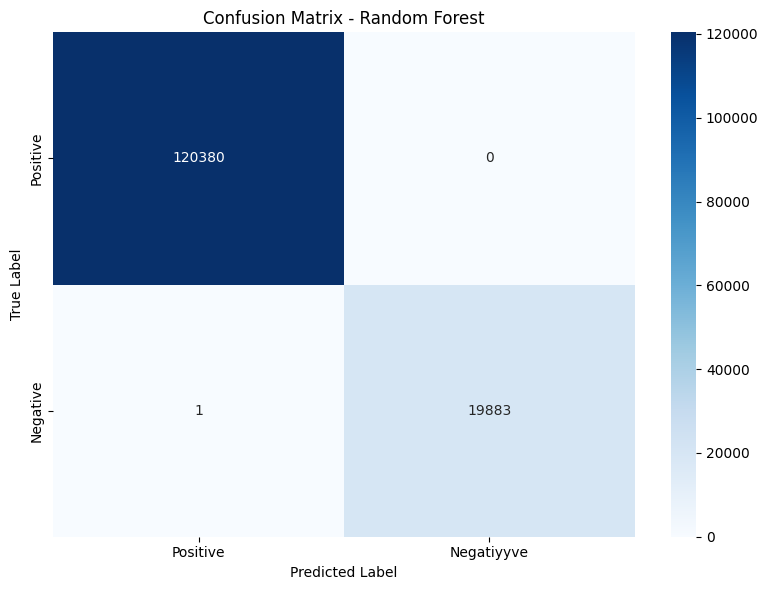


Detailed Metrics for Random Forest:
  True Positives: 19883
  True Negatives: 120380
  False Positives: 0
  False Negatives: 1
  Precision: 1.0000
  Recall (Sensitivity): 0.9999
  Specificity: 1.0000
  F1-Score: 1.0000


In [65]:
# TEST 8: Confusion Matrix Analysis
# Detailed analysis of model predictions

print("=" * 60)
print("TEST 8: Confusion Matrix Analysis")
print("=" * 60)

# Get best model based on ROC-AUC
best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train_extended)
y_pred_best = best_model.predict(X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test_extended, y_pred_best)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Positive', 'Negatiyyve'],
            yticklabels=['Positive', 'Negative'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.show()

# Calculate detailed metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nDetailed Metrics for {best_model_name}:")
print(f"  True Positives: {tp}")
print(f"  True Negatives: {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall (Sensitivity): {recall:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  F1-Score: {f1:.4f}")


TEST 9: Feature Set Comparison
Baseline (VADER + Rating): ROC-AUC = 1.000000
With TextBlob: ROC-AUC = 1.000000
With Text Features: ROC-AUC = 1.000000
With Time Features: ROC-AUC = 1.000000
All Features: ROC-AUC = 1.000000


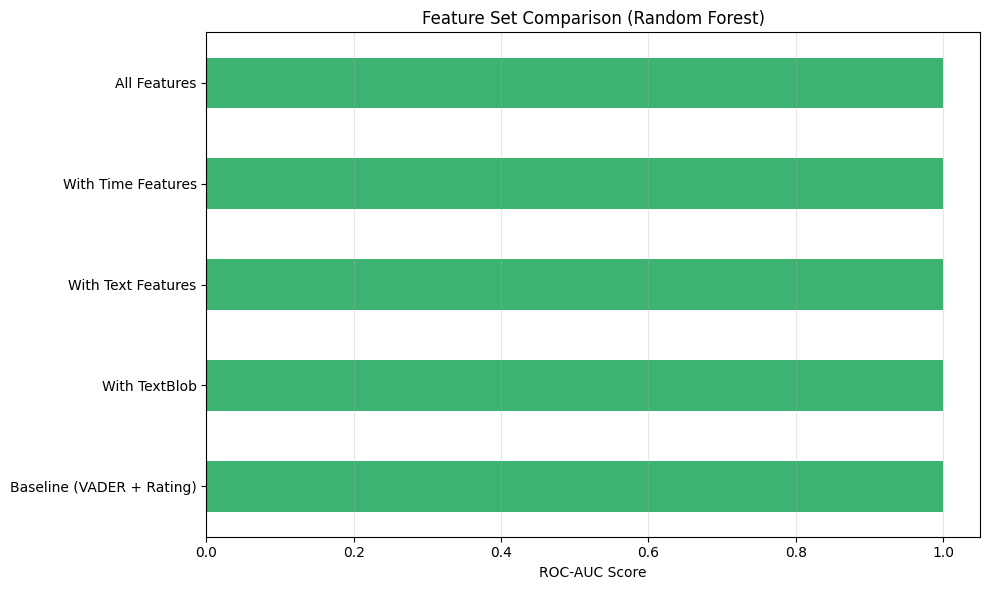

In [66]:
# TEST 9: Feature Set Comparison
# Compare performance with different feature combinations

print("=" * 60)
print("TEST 9: Feature Set Comparison")
print("=" * 60)

feature_sets = {
    'Baseline (VADER + Rating)': ['compound', 'rating'],
    'With TextBlob': ['compound', 'textblob_polarity', 'rating'],
    'With Text Features': ['compound', 'textblob_polarity', 'rating', 'review_length', 'word_count'],
    'With Time Features': ['compound', 'textblob_polarity', 'rating', 'review_length', 
                          'word_count', 'hour_sin', 'hour_cos'],
    'All Features': feature_cols
}

feature_results = {}

for set_name, features in feature_sets.items():
    # Extract features from already-split data
    X_train_feat = df_train[features].fillna(0)
    X_test_feat = df_test[features].fillna(0)
    y_train_feat = df_train['is_negative']
    y_test_feat = df_test['is_negative']
    
    scaler_feat = StandardScaler()
    X_train_feat_scaled = scaler_feat.fit_transform(X_train_feat)
    X_test_feat_scaled = scaler_feat.transform(X_test_feat)
    
    # Use Random Forest for comparison
    rf_feat = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_feat.fit(X_train_feat_scaled, y_train_feat)
    y_prob_feat = rf_feat.predict_proba(X_test_feat_scaled)[:, 1]
    
    roc_auc_feat = roc_auc_score(y_test_feat, y_prob_feat)
    feature_results[set_name] = roc_auc_feat
    print(f"{set_name}: ROC-AUC = {roc_auc_feat:.6f}")

# Visualize
plt.figure(figsize=(10, 6))
pd.Series(feature_results).sort_values(ascending=True).plot(kind='barh', color='mediumseagreen')
plt.xlabel('ROC-AUC Score')
plt.title('Feature Set Comparison (Random Forest)')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


In [67]:
# TEST 10: Summary Report
# Generate a comprehensive summary of all tests

print("=" * 60)
print("TEST 10: COMPREHENSIVE SUMMARY REPORT")
print("=" * 60)

# Check if required variables exist
required_vars = ['df', 'feature_cols', 'correlation', 'results', 'cv_results', 
                 'corr_coef', 'corr_p', 't_p', 'feature_importance', 'feature_results']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print("\n⚠️  WARNING: Missing required variables!")
    print("   Please run cells 1-21 in order before running this summary.")
    print(f"   Missing variables: {', '.join(missing_vars)}")
    print("\n   Required execution order:")
    print("   1. Cells 1-11: Data loading and preprocessing")
    print("   2. Cell 12: Testing framework setup")
    print("   3. Cells 13-21: All test cells")
    print("   4. Cell 22: This summary report")
else:
    print("\n1. DATASET OVERVIEW")
    # Use combined data for summary
    df_combined = pd.concat([df_train, df_val, df_test], ignore_index=True)
    print(f"   Total samples: {len(df_combined):,}")
    print(f"   Features: {len(feature_cols)}")
    print(f"   Target distribution:")
    print(f"     Negative reviews: {df_combined['is_negative'].sum():,} ({df_combined['is_negative'].mean()*100:.2f}%)")
    print(f"     Positive reviews: {(~df_combined['is_negative'].astype(bool)).sum():,} ({(1-df_combined['is_negative'].mean())*100:.2f}%)")

    print("\n2. SENTIMENT ANALYSIS METHODS")
    if 'correlation' in globals():
        print(f"   VADER-TextBlob correlation: {correlation:.4f}")
    else:
        print("   VADER-TextBlob correlation: Not calculated (run TEST 1)")

    print("\n3. BEST MODEL PERFORMANCE")
    if 'results' in globals() and len(results) > 0:
        best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
        best_metrics = results[best_model_name]
        print(f"   Model: {best_model_name}")
        print(f"   ROC-AUC: {best_metrics['roc_auc']:.6f}")
        print(f"   Accuracy: {best_metrics['accuracy']:.6f}")
        print(f"   Training time: {best_metrics['train_time']:.2f}s")
    else:
        print("   Model results: Not available (run TEST 3)")

    print("\n4. CROSS-VALIDATION RESULTS")
    if 'cv_results' in globals() and len(cv_results) > 0:
        best_cv = max(cv_results.items(), key=lambda x: x[1]['mean_cv_auc'])[0]
        print(f"   Best CV model: {best_cv}")
        print(f"   Mean CV ROC-AUC: {cv_results[best_cv]['mean_cv_auc']:.6f}")
    else:
        print("   CV results: Not available (run TEST 4)")

    print("\n5. STATISTICAL FINDINGS")
    if 'corr_coef' in globals() and 'corr_p' in globals():
        print(f"   Sentiment-Rating correlation: {corr_coef:.4f} (p={corr_p:.2e})")
    else:
        print("   Sentiment-Rating correlation: Not calculated (run TEST 6)")
    
    if 't_p' in globals():
        print(f"   Morning vs Evening difference: {'Significant' if t_p < 0.05 else 'Not significant'}")
    else:
        print("   Morning vs Evening difference: Not calculated (run TEST 6)")

    print("\n6. TOP FEATURES")
    if 'feature_importance' in globals():
        print("   Most important features (Random Forest):")
        for idx, row in feature_importance.head(5).iterrows():
            print(f"     {row['feature']}: {row['importance']:.4f}")
    else:
        print("   Feature importance: Not calculated (run TEST 5)")

    print("\n7. RECOMMENDATIONS")
    if 'results' in globals() and len(results) > 0:
        best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
        print("   - Best performing model: " + best_model_name)
    else:
        print("   - Best performing model: Not determined (run TEST 3)")
    
    if 'feature_results' in globals() and len(feature_results) > 0:
        print("   - Optimal feature set: " + max(feature_results.items(), key=lambda x: x[1])[0])
    else:
        print("   - Optimal feature set: Not determined (run TEST 9)")
    
    print("   - Consider using cross-validation for production models")

    print("\n" + "=" * 60)
    print("All tests completed successfully!")
    print("=" * 60)


TEST 10: COMPREHENSIVE SUMMARY REPORT

1. DATASET OVERVIEW
   Total samples: 701,316
   Features: 13
   Target distribution:
     Negative reviews: 99,673 (14.21%)
     Positive reviews: 601,643 (85.79%)

2. SENTIMENT ANALYSIS METHODS
   VADER-TextBlob correlation: 0.5678

3. BEST MODEL PERFORMANCE
   Model: Random Forest
   ROC-AUC: 1.000000
   Accuracy: 0.999993
   Training time: 12.08s

4. CROSS-VALIDATION RESULTS
   Best CV model: Random Forest
   Mean CV ROC-AUC: 1.000000

5. STATISTICAL FINDINGS
   Sentiment-Rating correlation: 0.6054 (p=0.00e+00)
   Morning vs Evening difference: Significant

6. TOP FEATURES
   Most important features (Random Forest):
     compound: 0.8141
     textblob_polarity: 0.1042
     rating: 0.0700
     word_count: 0.0028
     review_length: 0.0024

7. RECOMMENDATIONS
   - Best performing model: Random Forest
   - Optimal feature set: Baseline (VADER + Rating)
   - Consider using cross-validation for production models

All tests completed successfully!
